In [1]:
!pip install networkx
!pip install requests

In [ ]:
import json
import networkx as nx
import pandas as pd
from metrics.compute_avarage_degree import ComputeAverageDegree
from metrics.compute_packages_reached_by_vuln import ComputePackagesReachedByVuln
from metrics.compute_clustering_coefficient import ComputeClusteringCoefficient
from metrics.compute_degree_centrality import ComputeDegreeCentrality
from graph_analysis.metrics.degrees import ComputeOutDegree, ComputeInDegree
from metrics.number_of_vul_per_packages import ComputeVulPackagesSucessor
from metrics.compute_pct_of_the_network_reached_by_set import ComputePctgOftheNetworkReached
from metrics.compute_centralities import BetweennessCentrality, ClosenessCentrality, EigenvectorCentrality,  DegreeCentrality
from metrics.number_of_reachable_packages import ComputeNumOfReachablePkgs
from metrics.compute_pagerank import ComputePageRank
from metrics.compute_density import ComputeDensity
from metrics.compute_nodes_and_edges import ComputeNodesAndEdges
from graph_builder import build_dependency_graph

# Construção do Grafo

O código a seguir carrega dados de um arquivo JSON (.json`) para criar o grafo e o dicionário de vulnerabilidades, onde as chaves são os nomes dos pacotes em minúsculas e os valores são listas de vulnerabilidades associadas a cada pacote. Em seguida, exibe o nome e as vulnerabilidades de pacotes que possuem vulnerabilidades registradas.

In [2]:
data = json.load(open('03-11.json'))

vulnerability_dict = {
    package['name'].lower(): [vul for vul in package.get('package_vulnerabilities', [])]
    for package in data
}

for vul in vulnerability_dict:
    if len(vulnerability_dict[vul]):
        print(vul, vulnerability_dict[vul])


coapthon [{'aliases': ['CVE-2018-12680'], 'details': 'The Serialize.deserialize() method in CoAPthon 3.1, 4.0.0, 4.0.1, and 4.0.2 mishandles certain exceptions, leading to a denial of service in applications that use this library (e.g., the standard CoAP server, CoAP client, CoAP reverse proxy, example collect CoAP server and client) when they receive crafted CoAP messages.', 'fixed_in': [], 'id': 'PYSEC-2019-165', 'link': 'https://osv.dev/vulnerability/PYSEC-2019-165', 'source': 'osv', 'summary': None, 'withdrawn': None}, {'aliases': ['CVE-2018-12680'], 'details': 'The Serialize.deserialize() method in CoAPthon 3.1, 4.0.0, 4.0.1, and 4.0.2 mishandles certain exceptions, leading to a denial of service in applications that use this library (e.g., the standard CoAP server, CoAP client, CoAP reverse proxy, example collect CoAP server and client) when they receive crafted CoAP messages.', 'fixed_in': [], 'id': 'GHSA-5xc6-fpc7-4qvg', 'link': 'https://osv.dev/vulnerability/GHSA-5xc6-fpc7-4qv

In [3]:
packages = {package['name']: package for package in data}
graph = build_dependency_graph(packages, vulnerability_dict)

In [4]:
num_of_nodes, num_of_edges = ComputeNodesAndEdges()(graph)
density = ComputeDensity()(graph)

print("Original graph num of nodes:", num_of_nodes)
print("Original graph num of edges:", num_of_edges)
print("Original graph density:", density)

Original graph num of nodes: 593025
Original graph num of edges: 569644
Original graph density: 3.239576582556739e-06


# Redução do grafo

O código faz uma copia do grafo original, remove componentes triviais (nós isolados) e calcula o número de nós, arestas e a densidade do grafo reduzido, exibindo esses resultados no console.

- Interessante notar que o grafo reduziu de 500 mil nós para cerca de 180 mil 

In [5]:
graph_without_trivial_com = graph.copy()
components = nx.weakly_connected_components(graph)
trivial_nodes = [node for component in components if len(component) == 1 for node in component]
graph_without_trivial_com.remove_nodes_from(trivial_nodes)

num_of_nodes, num_of_edges = ComputeNodesAndEdges()(graph_without_trivial_com)
density = ComputeDensity()(graph_without_trivial_com)

print("num of nodes:", num_of_nodes)
print("num of edges:", num_of_edges)
print("graph density:", density)

num of nodes: 181225
num of edges: 569565
graph density: 3.468482192521397e-05


In [8]:
pkgs_vul_impact = ComputeVulPackagesSucessor().to_dataframe(graph_without_trivial_com.reverse())

pkgs_vul_impact.sort_values(by='num_of_sucessors', ascending=False)

,vulnerable_package,vulnerabilities_ids,successors,num_of_sucessors
0,flask-cors,[PYSEC-2024-71],"{qstrader-pro, neuroevobench, sphinx-quant, ba...",512
1,langchain,"[PYSEC-2024-111, PYSEC-2024-115]","{qstrader-pro, llama3-package, langchain-model...",471
3,pycrypto,"[PYSEC-2017-94, PYSEC-2018-97, GHSA-6528-wvf6-...","{django-paytm-checkout, dynamo-store, netcloud...",138
4,py,"[GHSA-w596-4wvx-j9j6, PYSEC-2022-42969]","{pytest-webdriver, pyctdev, codedepot-depot, c...",74
11,kerberos,[PYSEC-2017-49],"{django-auth-spnego, iiblib, pubtools-iib, pub...",4
9,rencode,"[PYSEC-2021-345, GHSA-gh8j-2pgf-x458]","{cloudbreak, aiodeluge, deluge}",3
5,flask-user,"[PYSEC-2021-337, GHSA-4298-89hc-6rfv]","{link-crab, tendril-framework, cornerstonecms}",3
13,restkit,[PYSEC-2017-69],"{jiraclient, baruwaapi}",2
2,coapthon,"[PYSEC-2019-165, GHSA-5xc6-fpc7-4qvg]",{aihub-things},1
7,xml2dict,"[PYSEC-2021-349, GHSA-gp6m-vqhm-5cm5]",{jinjamator},1


In [ ]:
num_of_used_by = ComputeNumOfReachablePkgs().to_dataframe(graph_without_trivial_com.reverse())
nodes_in_degree = ComputeInDegree().to_dataframe(graph_without_trivial_com)
nodes_out_degree = ComputeOutDegree().to_dataframe(graph_without_trivial_com)
sorted_pagerank = ComputePageRank().to_dataframe(graph_without_trivial_com)

sorted_pagerank = sorted(sorted_pagerank.items(), key=lambda x: x[1], reverse=True)

for pkg, page_rank in sorted_pagerank[:20]:
    print(f'Origin: {pkg} ; Page rank:{page_rank}; Num_depends: {num_of_used_by[pkg]}; Grau de saida: {nodes_out_degree[pkg]} Graud de entrada: {nodes_in_degree[pkg]} ; pct_of_the_network: {round(num_of_used_by[pkg] / graph_without_trivial_com.number_of_nodes(), ndigits=4)}')

Origin: requests ; Page rank:0.03748008651579226; Num_depends: 37089; Grau de saida: 0 Graud de entrada: 29296 ; pct_of_the_network: 0.2047
Origin: numpy ; Page rank:0.033112179668531395; Num_depends: 41704; Grau de saida: 0 Graud de entrada: 33228 ; pct_of_the_network: 0.2301
Origin: pandas ; Page rank:0.015930081296219728; Num_depends: 23521; Grau de saida: 0 Graud de entrada: 21291 ; pct_of_the_network: 0.1298
Origin: matplotlib ; Page rank:0.008808790289514779; Num_depends: 18454; Grau de saida: 0 Graud de entrada: 13847 ; pct_of_the_network: 0.1018
Origin: typing-extensions ; Page rank:0.008053092377669635; Num_depends: 14789; Grau de saida: 0 Graud de entrada: 1695 ; pct_of_the_network: 0.0816
Origin: scipy ; Page rank:0.008017056741995049; Num_depends: 15696; Grau de saida: 0 Graud de entrada: 12871 ; pct_of_the_network: 0.0866
Origin: pyyaml ; Page rank:0.008003231803714922; Num_depends: 13467; Grau de saida: 0 Graud de entrada: 8774 ; pct_of_the_network: 0.0743
Origin: click ;

In [25]:
sorted_pagerank = ComputePageRank()(graph_without_trivial_com)

sorted_pagerank = sorted(sorted_pagerank.items(), key=lambda x: x[1], reverse=True)

for pkg, num in sorted_pagerank[:20]:
    print(f'Package: {pkg} ; Page-Rank: {num}')

Package: requests ; Page-Rank: 0.03748008651579226
Package: numpy ; Page-Rank: 0.033112179668531395
Package: pandas ; Page-Rank: 0.015930081296219728
Package: matplotlib ; Page-Rank: 0.008808790289514779
Package: typing-extensions ; Page-Rank: 0.008053092377669635
Package: scipy ; Page-Rank: 0.008017056741995049
Package: pyyaml ; Page-Rank: 0.008003231803714922
Package: click ; Page-Rank: 0.007286565303425646
Package: setuptools ; Page-Rank: 0.006981957670621457
Package: beautifulsoup4 ; Page-Rank: 0.006301807959600993
Package: tqdm ; Page-Rank: 0.00614975645700604
Package: packaging ; Page-Rank: 0.005733718241947499
Package: pillow ; Page-Rank: 0.004868299243917789
Package: six ; Page-Rank: 0.004752870789593418
Package: python-dateutil ; Page-Rank: 0.004520669656039244
Package: aiohttp ; Page-Rank: 0.003427905377122195
Package: jinja2 ; Page-Rank: 0.0033839178754834667
Package: torch ; Page-Rank: 0.003079927707575248
Package: scikit-learn ; Page-Rank: 0.0030542651333286927
Package: fl

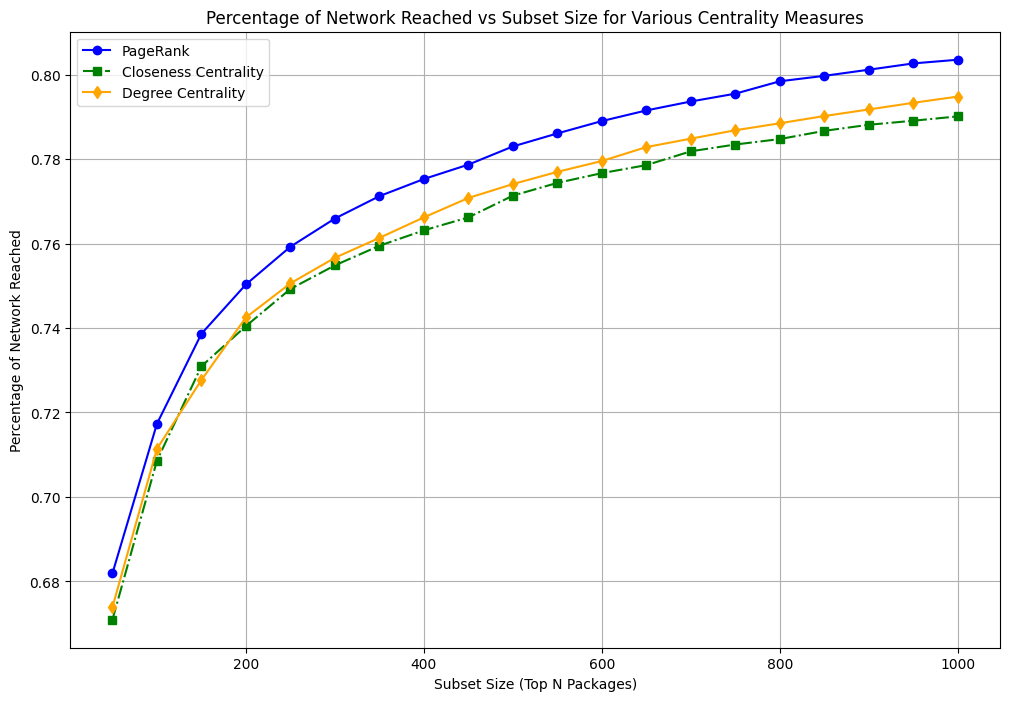

In [44]:
import matplotlib.pyplot as plt

# Calculate the top 1000 nodes by each centrality measure
subset_pagerank = [pkg for pkg, _ in sorted_pagerank[:1000]]
#subset_btw_centrality = [pkg for pkg, _ in sorted_btw_centrality[:1000]]
subset_closeness = [pkg for pkg, _ in sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:1000]]
# subset_eigenvector = [pkg for pkg, _ in sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:1000]]
subset_degree = [pkg for pkg, _ in sorted(nodes_in_degree.items(), key=lambda x: x[1], reverse=True)[:1000]]

# Initialize lists to store percentages for each metric
percentages_pagerank = []
percentages_btw_centrality = []
percentages_closeness = []
percentages_eigenvector = []
percentages_degree = []

STEP = 50
compute_pct_network = ComputePctgOftheNetworkReached()

for i in range(1, 21):
    subset_size = i * STEP
    
    # Calculate percentage of network reached for each centrality measure
    percentages_pagerank.append(compute_pct_network(graph_without_trivial_com.reverse(), subset_pagerank[:subset_size]))
    # percentages_btw_centrality.append(compute_pct_network(graph_without_trivial_com.reverse(), subset_btw_centrality[:subset_size]))
    percentages_closeness.append(compute_pct_network(graph_without_trivial_com.reverse(), subset_closeness[:subset_size]))
    # percentages_eigenvector.append(compute_pct_network(graph_without_trivial_com.reverse(), subset_eigenvector[:subset_size]))
    percentages_degree.append(compute_pct_network(graph_without_trivial_com.reverse(), subset_degree[:subset_size]))

# Plotting
subset_sizes = [i * STEP for i in range(1, 21)]  # x-axis values (10, 20, ..., 100)

plt.figure(figsize=(12, 8))
plt.plot(subset_sizes, percentages_pagerank, marker='o', color='b', linestyle='-', label="PageRank")
# plt.plot(subset_sizes, percentages_btw_centrality, marker='x', color='r', linestyle='--', label="Betweenness Centrality")
plt.plot(subset_sizes, percentages_closeness, marker='s', color='g', linestyle='-.', label="Closeness Centrality")
# plt.plot(subset_sizes, percentages_eigenvector, marker='^', color='purple', linestyle=':', label="Eigenvector Centrality")
plt.plot(subset_sizes, percentages_degree, marker='d', color='orange', linestyle='-', label="Degree Centrality")

plt.xlabel("Subset Size (Top N Packages)")
plt.ylabel("Percentage of Network Reached")
plt.title("Percentage of Network Reached vs Subset Size for Various Centrality Measures")
plt.legend()
plt.grid(True)
plt.savefig('chart.pdf')
plt.show()

In [43]:
plt.savefig('chart.png')

<Figure size 640x480 with 0 Axes>

In [33]:
import networkx as nx

def mark_reachable_nodes(graph: nx.DiGraph, top_10_pagerank: list[str]) -> None:
    """
    Marca os nós alcançáveis a partir dos pacotes de top-10 PageRank.
    Os nós alcançados recebem o atributo 'status' com o nome do pacote que os alcançou.
    Aqueles que não são alcançados por nenhum pacote são marcados como 'não alcançado'.
    
    :param graph: Grafo direcionado
    :param top_10_pagerank: Lista de pacotes com os 10 principais valores de PageRank
    """
    # Definindo o atributo de todos os nós como 'não alcançado' inicialmente
    nx.set_node_attributes(graph, 'não alcançado', 'alcançado por')

    # Função para realizar a busca em profundidade e marcar os nós alcançados
    def dfs(node, reached_from):
        if graph.nodes[node]['alcançado por'] != 'não alcançado':
            return
        
        graph.nodes[node]['alcançado por'] = reached_from

        # Percorre os vizinhos do nó
        for neighbor in graph.successors(node):
            dfs(neighbor, reached_from)

    # Realiza a busca a partir dos top-10 pacotes
    for pkg in top_10_pagerank:
        if pkg in graph:
            dfs(pkg, pkg)
    

mark_reachable_nodes(graph_without_trivial_com.reverse(), subset_pagerank[:10])



In [34]:
import networkx as nx
import csv

def export_graph_to_csv(graph: nx.Graph, nodes_filename: str, edges_filename: str):
    # Exportar nós para CSV
    with open(nodes_filename, 'w', newline='', encoding='utf-8') as nodes_file:
        writer = csv.writer(nodes_file)
        writer.writerow(['id', 'alcançado por'])  # Cabeçalho, ajustado conforme os atributos do nó
        
        # Escrever os dados dos nós (nós e o atributo 'status' de cada nó)
        for node, data in graph.nodes(data=True):
            writer.writerow([node, data.get('alcançado por', 'não disponível')])  # O status pode ser opcional
    
    # Exportar arestas para CSV
    with open(edges_filename, 'w', newline='', encoding='utf-8') as edges_file:
        writer = csv.writer(edges_file)
        writer.writerow(['Source', 'Target'])  # Cabeçalho para arestas
        
        # Escrever as arestas
        for source, target in graph.edges():
            writer.writerow([source, target])

export_graph_to_csv(reverse_graph_without_trivial_com, 'nodes.csv', 'edges.csv')


In [69]:
num_of_dependicies = ComputeNumOfReachablePkgs()(graph_without_trivial_com)

for pkg, num in sorted(num_of_dependicies.items(), key=lambda x: x[1], reverse=True)[:20]:
    print(f'Affected: {pkg} ; Num_depends: {num}')

Affected: superpilot ; Num_depends: 368
Affected: cpskin.demo ; Num_depends: 278
Affected: brasil.gov.portal ; Num_depends: 277
Affected: brasil.gov.temas ; Num_depends: 277
Affected: cpskin.policy ; Num_depends: 273
Affected: ideabox.policy ; Num_depends: 253
Affected: design.plone.iocittadino ; Num_depends: 238
Affected: imio.directory.policy ; Num_depends: 237
Affected: imio.events.policy ; Num_depends: 234
Affected: design.plone.ioprenoto ; Num_depends: 234
Affected: imio.news.policy ; Num_depends: 233
Affected: bda.plone.stripe ; Num_depends: 233
Affected: bda.plone.productshop ; Num_depends: 233
Affected: design.plone.policy ; Num_depends: 233
Affected: bda.plone.shop ; Num_depends: 231
Affected: bda.plone.orders ; Num_depends: 229
Affected: design.plone.contenttypes ; Num_depends: 229
Affected: oira.statistics.tools ; Num_depends: 228
Affected: rer.newsletterplugin.flask ; Num_depends: 228
Affected: imio.smartweb.policy ; Num_depends: 227


In [14]:
critical = []

# Convert the first 10,000 elements of num_of_dependencies and num_of_used_by to sets of package names
dep_set = set(dep[0] for dep in sorted(num_of_dependicies.items(), key=lambda x: x[1], reverse=True)[:1000])
used_by_set = set(used_by[0] for used_by in sorted(num_of_used_by.items(), key=lambda x: x[1], reverse=True)[:1000])

# Assuming graph_without_trivial_com is a list of package names (strings)
for pkg in dep_set:
    if pkg in used_by_set:
        critical.append(pkg)

for pkg in critical:
    print(f'{pkg} -> used_by: {num_of_used_by[pkg]}; depends_on: {num_of_dependicies[pkg]}')


plone.base -> used_by: 293; depends_on: 82
plone.z3cform -> used_by: 298; depends_on: 67
plone.registry -> used_by: 301; depends_on: 63
plone.restapi -> used_by: 108; depends_on: 81
plone.folder -> used_by: 228; depends_on: 78
plone.app.uuid -> used_by: 254; depends_on: 80
products.extendedpathindex -> used_by: 191; depends_on: 71
products.zopeversioncontrol -> used_by: 193; depends_on: 63
plone.app.intid -> used_by: 217; depends_on: 59
plone.app.querystring -> used_by: 215; depends_on: 119
plone.app.versioningbehavior -> used_by: 200; depends_on: 121
plone.session -> used_by: 198; depends_on: 90
plone.app.contenttypes -> used_by: 199; depends_on: 154
plone.portlet.collection -> used_by: 191; depends_on: 154
five.customerize -> used_by: 196; depends_on: 69
plone.app.contentrules -> used_by: 192; depends_on: 159
products.plonepas -> used_by: 197; depends_on: 105
plone.app.registry -> used_by: 210; depends_on: 113
products.isurlinportal -> used_by: 191; depends_on: 83
products.cmfdifftoo

In [30]:
in_degree_centrality = nx.in_degree_centrality(graph_without_trivial_com).items()
sorted(in_degree_centrality, key=lambda x: x[1], reverse=True)[:10]

[('numpy', 0.18335319825188717),
 ('requests', 0.1616562927647552),
 ('pandas', 0.11748443914713283),
 ('matplotlib', 0.07640820200414956),
 ('scipy', 0.07102260186288792),
 ('tqdm', 0.051963316117070585),
 ('pyyaml', 0.04841522094203858),
 ('click', 0.04165011256787181),
 ('beautifulsoup4', 0.033533086125457995),
 ('scikit-learn', 0.03188319427890346)]

In [31]:
out_degree_centrality = nx.out_degree_centrality(graph_without_trivial_com).items()
sorted(out_degree_centrality, key=lambda x: x[1], reverse=True)[:10]

[('superpilot', 0.0019809738224517725),
 ('hammadml-gpu', 0.0010980885533924867),
 ('python-core', 0.0010263541252814197),
 ('project-to-installer', 0.0010263541252814197),
 ('pyicarus', 0.0010208360923497993),
 ('types-all-v2', 0.000915993466649009),
 ('llm-explorer', 0.000915993466649009),
 ('lohrasb', 0.0008277049397430804),
 ('vaspsol', 0.0007945967421533572),
 ('types-all-latest', 0.0007945967421533572)]

In [46]:
num_nodes = graph.number_of_nodes()
k = max(1, int(0.01 * num_nodes))  # Example: 1% of total nodes, at least 1
btw_centrality = nx.betweenness_centrality(graph_without_trivial_com, k=k)

In [ ]:
sorted_btw_centrality = sorted(btw_centrality.items(), key=lambda x: x[1], reverse=True)

In [64]:
for i in sorted_btw_centrality[:10]:
    print(i, "in degree", num_of_used_by[i[0]], "out degree", num_of_dependicies[i[0]])

('torch', 5.326557969881628e-07) in degree 4430 out degree 4
('beautifulsoup4', 2.848998978213001e-07) in degree 10085 out degree 1
('jupyter', 2.735783449955217e-07) in degree 601 out degree 20
('plone.api', 2.72872696958915e-07) in degree 160 out degree 200
('ipython', 2.7264780640710154e-07) in degree 2238 out degree 5
('products.cmfplone', 2.4772123490503763e-07) in degree 190 out degree 198
('pytest', 2.1441159974847437e-07) in degree 3360 out degree 2
('httpx', 1.8750352556665856e-07) in degree 1795 out degree 3
('keras', 1.6183616950273634e-07) in degree 446 out degree 8
('uniswap-v3-liquidity-pool-simulator', 1.6098317579668452e-07) in degree 1 out degree 207


In [16]:
closeness_centrality = ClosenessCentrality()(graph_without_trivial_com)
eigenvector_centrality = EigenvectorCentrality()(graph_without_trivial_com)
degree_centrality = DegreeCentrality()(graph_without_trivial_com)

In [40]:
sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)

[('tea-xyz2', 0.3655124198354138),
 ('tea-xyz1', 0.3655124198354138),
 ('teaxyz', 0.23840288848220284),
 ('teaxyzz', 0.23840288848220284),
 ('teaxyzzz', 0.23840288848220284),
 ('teaxyzzzz', 0.23840288848220284),
 ('teaxyzzzzz', 0.23840288848220284),
 ('teaxyzzzzzz', 0.23840288848220284),
 ('teaxyzzz9', 0.14315327166196606),
 ('teaxyzzz10', 0.14315327166196606),
 ('teaxyzzz11', 0.14315327166196606),
 ('teaxyzzz12', 0.14315327166196606),
 ('teaxyzzz13', 0.14315327166196606),
 ('teaxyzzz14', 0.14315327166196606),
 ('teaxyzzz15', 0.14315327166196606),
 ('teaxyzzz16', 0.14315327166196606),
 ('teaxyzzz17', 0.14315327166196606),
 ('teaxyzzz18', 0.14315327166196606),
 ('teaxyzzz19', 0.14315327166196606),
 ('teaxyzzz20', 0.14315327166196606),
 ('teaxyzzz1', 0.13256081071586512),
 ('teaxyzzz2', 0.13256081071586512),
 ('teaxyzzz3', 0.13256081071586512),
 ('teaxyzzz4', 0.13256081071586512),
 ('teaxyzzz5', 0.13256081071586512),
 ('teaxyzzz6', 0.13256081071586512),
 ('teaxyzzz7', 0.13256081071586512

In [ ]:
cicles = nx.simple_cycles(graph_without_trivial_com)

In [ ]:
for i in cicles:
    print(i)

NameError: name 'cicles' is not defined

In [ ]:
sorted(btw_centrality.items(), key=lambda x: x[1], reverse=True)

[('torch', 5.632084806412908e-07),
 ('plone.api', 5.607065583514809e-07),
 ('zope', 3.8444340288560775e-07),
 ('ipython', 3.7547232042752724e-07),
 ('jupyter', 3.7547232042752724e-07),
 ('beautifulsoup4', 3.0599210582549e-07),
 ('products.cmfplone', 2.851757360457247e-07),
 ('pytest', 2.240825543638408e-07),
 ('plone.app.dexterity', 1.5750684349047347e-07),
 ('node', 1.4218629631059768e-07),
 ('httpx', 1.405113268514414e-07),
 ('discorudo', 1.3958078826302126e-07),
 ('keras', 1.3291192837934357e-07),
 ('suiutils-py', 1.3064761781418787e-07),
 ('nbconvert', 1.2701851731934934e-07),
 ('keyring', 1.1321552825778392e-07),
 ('products.cmfcore', 1.1142927685704712e-07),
 ('bs4', 1.1073409202199687e-07),
 ('jupyter-console', 1.0887301484515659e-07),
 ('plone.app.mosaic', 1.0465571459756559e-07),
 ('nltk', 8.79358966057034e-08),
 ('plone.protect', 8.601389130700227e-08),
 ('datasets', 8.589757398344974e-08),
 ('plone.app.layout', 8.074849308655219e-08),
 ('stack-data', 8.002631860413219e-08),


In [ ]:
import random
import requests
import time
import statistics

def get_dependent_packages_from_librariesio(package_name):
    url = f"https://libraries.io/api/pypi/{package_name}"
    params = {
        'api_key': '8ba1a7bcdf5a2530fffb19abed86fc46',
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()
        return data['dependents_count']
    else:
        print(f"Erro ao obter dados para {package_name}")
        return None

def calculate_absolute_error(computed_count, libraries_io_count):
    return abs(computed_count - libraries_io_count)

num: dict = ComputeNumOfReachablePkgs()(graph_without_trivial_com.reverse())
random_indices = random.sample(list(num.items()), 200)

batch_size = 40
batches = [random_indices[i:i + batch_size] for i in range(0, len(random_indices), batch_size)]

absolute_errors = []

for batch in batches:
    for package, computed_count in batch:
        libraries_io_count = get_dependent_packages_from_librariesio(package)
        
        if libraries_io_count is not None:
            absolute_error = calculate_absolute_error(computed_count, libraries_io_count)
            absolute_errors.append(absolute_error)
    
    time.sleep(10)

# Calcular a mediana dos erros absolutos
median_absolute_error = statistics.median(absolute_errors) if absolute_errors else 0
mean= statistics.mean(absolute_errors)

print(f"Lista de medianas: {absolute_errors}")
print(f"Mediana dos erros absolutos: {median_absolute_error}")
print(f"Erro medio dos pacotes: {mean}")


KeyboardInterrupt: 